In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from torch.utils.data import DataLoader, Dataset
import os
from PIL import Image

from tqdm import tqdm

import random

import hydra
from hydra import compose, initialize
from omegaconf import OmegaConf

from sam2.build_sam import build_sam2
from sam2.sam2_image_predictor import SAM2ImagePredictor
from sam2.automatic_mask_generator import SAM2AutomaticMaskGenerator

import numpy as np
import matplotlib.pyplot as plt
import cv2

C:\Users\matth\Programming\Research\2025\CVPR\SaRaCVPR\sam2\sam2\modeling\sam\transformer.py:23: UserWarning: Flash Attention is disabled as it requires a GPU with Ampere (8.0) CUDA capability.
  OLD_GPU, USE_FLASH_ATTN, MATH_KERNEL_ON = get_sdpa_settings()


In [2]:
CONFIG_PATH = "./sam2/sam2/configs/sam2.1/"
# YAML_CONFIG = "sam2.1_hiera_b+.yaml"
YAML_CONFIG = "sam2.1_hiera_t.yaml"

FULL_PATH = os.path.join(CONFIG_PATH, YAML_CONFIG)

TEST_IMG_PATH = "./test_images/"
images = os.listdir(TEST_IMG_PATH)
images = [f"{TEST_IMG_PATH}{img}" for img in images]

initialize(version_base=None, config_path=CONFIG_PATH, job_name="test_app")
cfg = compose(config_name=YAML_CONFIG, overrides=[])

# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: cuda


In [3]:
# checkpoint = "./sam2/checkpoints/sam2.1_hiera_base_plus.pt"
checkpoint = "./sam2/checkpoints/sam2.1_hiera_tiny.pt"
model_cfg = YAML_CONFIG
# predictor = SAM2ImagePredictor(build_sam2(YAML_CONFIG, checkpoint))
sam2 = build_sam2(model_cfg, checkpoint, device=device, apply_postprocessing=False)
predictor = SAM2AutomaticMaskGenerator(
    model=sam2,
    # points_per_side=16,
    # points_per_batch=16,
    # pred_iou_thresh=0.9,
    # stability_score_thresh=0.92,
    # stability_score_offset=0.7,
    # crop_n_layers=1,
    # box_nms_thresh=0.7,
    # crop_n_points_downscale_factor=2,
    # min_mask_region_area=200.0,
    # use_m2m=True,
)

# predictor = SAM2ImagePredictor(
#     sam_model=sam2,
# )

In [4]:
images_dir = './ASSR/images/train'
masks_dir = './ASSR/gt/train'

image_names = os.listdir(images_dir)
mask_names = os.listdir(masks_dir)

train_data = []

for img_name in image_names:
    if img_name[:-4] + '.png' in mask_names:
        train_data.append({
            'image': images_dir + '/' + img_name,
            'annotation': masks_dir + '/' + img_name[:-4] + '.png'
        })

In [5]:
test_images_dir = './ASSR/images/test'
test_masks_dir = './ASSR/gt/test'

test_image_names = os.listdir(test_images_dir)
test_mask_names = os.listdir(test_masks_dir)

test_data = []

for img_name in test_image_names:
    if img_name[:-4] + '.png' in test_mask_names:
        test_data.append({
            'image': test_images_dir + '/' + img_name,
            'annotation': test_masks_dir + '/' + img_name[:-4] + '.png'
        })

In [6]:
# predictor.model.sam_mask_decoder.train(True)
# predictor.model.sam_prompt_encoder.train(True)

In [7]:
def read_batch(data, visualize_data=False):
    # Select a random entry
    ent = data[np.random.randint(len(data))]

    # Get full paths
    Img = cv2.imread(ent["image"])[..., ::-1]  # Convert BGR to RGB
    ann_map = cv2.imread(ent["annotation"], cv2.IMREAD_GRAYSCALE)  # Read annotation as grayscale

    if Img is None or ann_map is None:
       print(f"Error: Could not read image or mask from path {ent['image']} or {ent['annotation']}")
       print(Img, ann_map)
       return None, None, None, 0

    # Resize image and mask
    r = np.min([1024 / Img.shape[1], 1024 / Img.shape[0]])  # Scaling factor
    Img = cv2.resize(Img, (int(Img.shape[1] * r), int(Img.shape[0] * r)))
    ann_map = cv2.resize(ann_map, (int(ann_map.shape[1] * r), int(ann_map.shape[0] * r)),    interpolation=cv2.INTER_NEAREST)

    # Initialize a single binary mask
    binary_mask = np.zeros_like(ann_map, dtype=np.uint8)
    points = []

    # Get binary masks and combine them into a single mask
    inds = np.unique(ann_map)[1:]  # Skip the background (index 0)
    for ind in inds:
        mask = (ann_map == ind).astype(np.uint8)  # Create binary mask for each unique index
        binary_mask = np.maximum(binary_mask, mask)  # Combine with the existing binary mask

    # Erode the combined binary mask to avoid boundary points
    eroded_mask = cv2.erode(binary_mask, np.ones((5, 5), np.uint8), iterations=1)

    # Get all coordinates inside the eroded mask and choose a random point
    coords = np.argwhere(eroded_mask > 0)
    if len(coords) > 0:
       for _ in inds:  # Select as many points as there are unique labels
           yx = np.array(coords[np.random.randint(len(coords))])
           points.append([yx[1], yx[0]])

    points = np.array(points)

    binary_mask = np.expand_dims(binary_mask, axis=-1)  # Now shape is (1024, 1024, 1)
    binary_mask = binary_mask.transpose((2, 0, 1))
    points = np.expand_dims(points, axis=1)

    # Return the image, binarized mask, points, and number of masks
    return Img, binary_mask, points, len(inds)

In [38]:
# Train mask decoder.
predictor.predictor.model.sam_mask_decoder.train(True)

# Train prompt encoder.
predictor.predictor.model.sam_prompt_encoder.train(True)


# Configure optimizer.
optimizer=torch.optim.AdamW(params=predictor.predictor.model.parameters(),lr=0.0001,weight_decay=1e-4) #1e-5, weight_decay = 4e-5

# Mix precision.
# scaler = torch.cuda.amp.GradScaler()

# No. of steps to train the model.
NO_OF_STEPS = 3000 # @param 

# Fine-tuned model name.
FINE_TUNED_MODEL_NAME = "fine_tuned_sam2_generator"

In [40]:
# Initialize scheduler
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=500, gamma=0.2) # 500 , 250, gamma = 0.1
accumulation_steps = 4  # Number of steps to accumulate gradients before updating

for step in range(1, NO_OF_STEPS + 1):
   with torch.cuda.amp.autocast():
        image, mask, input_point, num_masks = read_batch(train_data, visualize_data=False)
        if image is None or mask is None or num_masks == 0:
           continue

        input_label = np.ones((num_masks, 1))
        if not isinstance(input_point, np.ndarray) or not isinstance(input_label, np.ndarray):
            continue

        if input_point.size == 0 or input_label.size == 0:
            continue

    #    predictor.set_image(image)
    #    mask_input, unnorm_coords, labels, unnorm_box = predictor._prep_prompts(input_point, input_label, box=None, mask_logits=None, normalize_coords=True)
    #    if unnorm_coords is None or labels is None or unnorm_coords.shape[0] == 0 or labels.shape[0] == 0:
    #        continue

    #    sparse_embeddings, dense_embeddings = predictor.model.sam_prompt_encoder(
    #        points=(unnorm_coords, labels), boxes=None, masks=None,
    #    )

    #    batched_mode = unnorm_coords.shape[0] > 1
    #    high_res_features = [feat_level[-1].unsqueeze(0) for feat_level in predictor._features["high_res_feats"]]
    #    low_res_masks, prd_scores, _, _ = predictor.model.sam_mask_decoder(
    #        image_embeddings=predictor._features["image_embed"][-1].unsqueeze(0),
    #        image_pe=predictor.model.sam_prompt_encoder.get_dense_pe(),
    #        sparse_prompt_embeddings=sparse_embeddings,
    #        dense_prompt_embeddings=dense_embeddings,
    #        multimask_output=True,
    #        repeat_image=batched_mode,
    #        high_res_features=high_res_features,
    #    )
    #    prd_masks = predictor._transforms.postprocess_masks(low_res_masks, predictor._orig_hw[-1])

        pred = predictor.generate(image)
        if len(pred) == 0:
            continue
        
        prd_masks_tensor = torch.stack([torch.tensor(mask['segmentation']).cuda() for mask in pred])  # Ensure they're on the GPU
        gt_mask = torch.tensor(mask.astype(np.float32), requires_grad=True).cuda()
        # prd_mask = torch.sigmoid(prd_masks[:, 0])
        prd_mask = torch.sigmoid(prd_masks_tensor)

        seg_loss = (-gt_mask * torch.log(prd_mask + 0.000001) - (1 - gt_mask) * torch.log((1 - prd_mask) + 0.00001)).mean()
    
        inter = (gt_mask * (prd_mask > 0.5)).sum(1).sum(1)
        iou = inter / (gt_mask.sum(1).sum(1) + (prd_mask > 0.5).sum(1).sum(1) - inter)
        # score_loss = torch.abs(prd_scores[:, 0] - iou).mean()
        # loss = seg_loss + score_loss * 0.05
        loss = seg_loss
    
        # Apply gradient accumulation
        loss = loss / accumulation_steps

        # scaler.scale(loss).backward()
        loss.backward()
    
        # Clip gradients
        # torch.nn.utils.clip_grad_norm_(predictor.model.parameters(), max_norm=1.0)
        torch.nn.utils.clip_grad_norm_(predictor.predictor.model.parameters(), max_norm=1.0)
    
        # if step % accumulation_steps == 0:
        #     scaler.step(optimizer)
        #     scaler.update()
        #     predictor.model.zero_grad()
    
        # Update scheduler
        scheduler.step()
    
        if step % 500 == 0:
            FINE_TUNED_MODEL = FINE_TUNED_MODEL_NAME + "_" + str(step) + ".torch"
            # torch.save(predictor.model.state_dict(), FINE_TUNED_MODEL)
            torch.save(predictor.predictor.model.state_dict(), FINE_TUNED_MODEL)
    
        if step == 1:
            mean_iou = 0
    
        mean_iou = mean_iou * 0.99 + 0.01 * np.mean(iou.cpu().detach().numpy())
    
        # if step % 100 == 0:
        #    print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)
        print("Step " + str(step) + ":\t", "Accuracy (IoU) = ", mean_iou)


c:\Users\matth\anaconda3\envs\sara\Lib\site-packages\torch\optim\lr_scheduler.py:216: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  warnings.warn(


Step 1:	 Accuracy (IoU) =  4.791285376995802e-05
Step 2:	 Accuracy (IoU) =  0.00037331120544113224
Step 3:	 Accuracy (IoU) =  0.0006105656699310057
Step 4:	 Accuracy (IoU) =  0.0012194776880950341
Step 5:	 Accuracy (IoU) =  0.0017814568385212128
Step 6:	 Accuracy (IoU) =  0.0023536747209907793
Step 7:	 Accuracy (IoU) =  0.003424484318251849
Step 8:	 Accuracy (IoU) =  0.004793626067934321
Step 9:	 Accuracy (IoU) =  0.004796797521207639
Step 10:	 Accuracy (IoU) =  0.005027239582112401
Step 11:	 Accuracy (IoU) =  0.005065493913922965
Step 12:	 Accuracy (IoU) =  0.005759203534434157
Step 13:	 Accuracy (IoU) =  0.0061052313547321335
Step 14:	 Accuracy (IoU) =  0.0060741237395111015
Step 15:	 Accuracy (IoU) =  0.0060456996259574845
Step 16:	 Accuracy (IoU) =  0.00621474405591785
Step 17:	 Accuracy (IoU) =  0.006326296508416017
Step 18:	 Accuracy (IoU) =  0.006288201110987301
Step 19:	 Accuracy (IoU) =  0.00624800042741413
Step 20:	 Accuracy (IoU) =  0.007457854730572163
Step 21:	 Accuracy (I

RuntimeError: stack expects a non-empty TensorList

In [90]:
def read_image(image_path, mask_path):  # read and resize image and mask
   img = cv2.imread(image_path)[..., ::-1]  # Convert BGR to RGB
   mask = cv2.imread(mask_path, 0)
   r = np.min([1024 / img.shape[1], 1024 / img.shape[0]])
   img = cv2.resize(img, (int(img.shape[1] * r), int(img.shape[0] * r)))
   mask = cv2.resize(mask, (int(mask.shape[1] * r), int(mask.shape[0] * r)), interpolation=cv2.INTER_NEAREST)
   return img, mask

def get_points(mask, num_points):  # Sample points inside the input mask
   points = []
   coords = np.argwhere(mask > 0)
   for i in range(num_points):
       yx = np.array(coords[np.random.randint(len(coords))])
       points.append([[yx[1], yx[0]]])
   return np.array(points)

def generate_random_points(image, num_points):
    height, width, _ = image.shape
    points = np.random.randint(0, min(height, width), (num_points, 2))
    return points[:, np.newaxis, :]


In [91]:
image, mask = read_image('./ASSR/images/test/COCO_val2014_000000000192.jpg', './ASSR/gt/test/COCO_val2014_000000000192.png')

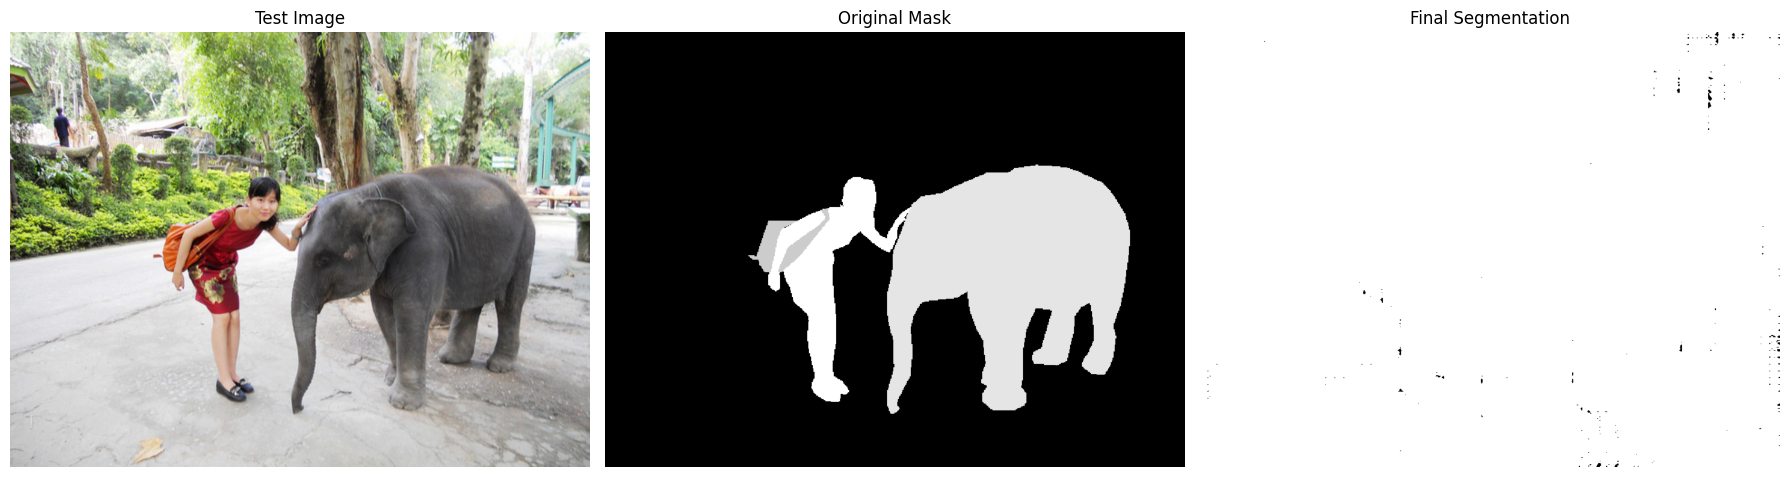

In [112]:
selected_entry = random.choice(test_data)
image_path = selected_entry['image']
mask_path = selected_entry['annotation']

# Load the selected image and mask
image, mask = read_image(image_path, mask_path)

# Generate random points for the input
num_samples = 10  # Number of points per segment to sample
# input_points = get_points(mask, num_samples)
input_points = generate_random_points(image, num_samples)

# Load the fine-tuned model
FINE_TUNED_MODEL_WEIGHTS = "fine_tuned_sam2_1000.torch"
sam2_model = build_sam2(model_cfg, checkpoint, device="cuda")

# Build net and load weights
predictor = SAM2ImagePredictor(sam2_model)
predictor.model.load_state_dict(torch.load(FINE_TUNED_MODEL_WEIGHTS))

# Perform inference and predict masks
with torch.no_grad():
   predictor.set_image(image)
   masks, scores, logits = predictor.predict(
       point_coords=input_points,
       point_labels=np.ones([input_points.shape[0], 1])
   )

# Process the predicted masks and sort by scores
np_masks = np.array(masks[:, 0])
np_scores = scores[:, 0]
sorted_masks = np_masks[np.argsort(np_scores)][::-1]

# Initialize segmentation map and occupancy mask
seg_map = np.zeros_like(sorted_masks[0], dtype=np.uint8)
occupancy_mask = np.zeros_like(sorted_masks[0], dtype=bool)

# Combine masks to create the final segmentation map
for i in range(sorted_masks.shape[0]):
   m = sorted_masks[i]
   if (m * occupancy_mask).sum() / m.sum() > 0.15:
       continue

   mask_bool = m.astype(bool)
   mask_bool[occupancy_mask] = False  # Set overlapping areas to False in the mask
   seg_map[mask_bool] = i + 1  # Use boolean mask to index seg_map
   occupancy_mask[mask_bool] = True  # Update occupancy_mask

# Visualization: Show the original image, mask, and final segmentation side by side
plt.figure(figsize=(18, 6))

plt.subplot(1, 3, 1)
plt.title('Test Image')
plt.imshow(image)
plt.axis('off')

plt.subplot(1, 3, 2)
plt.title('Original Mask')
plt.imshow(mask, cmap='gray')
plt.axis('off')

plt.subplot(1, 3, 3)
plt.title('Final Segmentation')
plt.imshow(seg_map, cmap='gray')
plt.axis('off')

plt.tight_layout()
plt.show()